In [1]:
from data_preparator import DataPreparator
data_preparator = DataPreparator()
from etoro_api import EtoroApi
from yahoo_api import YahooApi
import pandas as pd
from stock_predictor import StockPredictor
yahoo_api = YahooApi()
etoro_api = EtoroApi()
pd.set_option('display.max_rows', 500)

interval="FiveMinutes"
intervals_to_profit = 1
take_profit = 1.016
stop_loss=1.00

In [2]:
etoro_data = etoro_api.get_stock_data(1002, rows=110, interval=interval)
print(len(etoro_data))
etoro_data.head(1)

110


,rowIndex,FromDate,Close
0,0,2020-12-09T18:20:00Z,1799.29


In [3]:
data_preparator.prepare(etoro_data, only_last_row=True)

,momentum_2,momentum_2_5,momentum_3_8,momentum_5_10,momentum_5_20,momentum_10_30,williams_r,rsi
109,3.0,4.0,11.0,15.0,26.0,5.0,2.27,63.0


In [4]:
prepared_data = data_preparator.prepare(etoro_data, intervals_to_profit=intervals_to_profit, take_profit=take_profit, stop_loss=stop_loss)
print(len(prepared_data))

positive = prepared_data.loc[0:10]

true_negatives = prepared_data.copy()
del true_negatives["FromDate"]
del true_negatives["Close"]

model_filename = f'./models/{interval}-itp{intervals_to_profit}-tp{take_profit}-sl{stop_loss}.sav'
stock_predictor = StockPredictor(model_filename=model_filename, proba=0.8)
predicted_data = true_negatives.copy()
predicted_data["prediction"] = 0.00
for index, stock in predicted_data.iterrows():
    predicted_data.loc[index:index]["prediction"] = stock_predictor.should_buy(true_negatives.loc[index:index], get_proba=True)
# true_negatives["prediction"] = true_negatives.apply(lambda x: stock_predictor.should_buy(x), axis=1)
# true_negatives["prediction"] = stock_predictor.should_buy(true_negatives)
sorted_predicted_data = predicted_data.sort_values(by='prediction', ascending=False)
sorted_predicted_data.tail(10)

110


,momentum_2,momentum_2_5,momentum_3_8,momentum_5_10,momentum_5_20,momentum_10_30,williams_r,rsi,profit,prediction
28,17.0,2.0,-11.0,-11.0,-32.0,-45.0,14.81,57.0,False,0.389275
39,9.0,6.0,5.0,-15.0,-39.0,-46.0,0.00,29.0,False,0.389179
27,12.0,-11.0,-18.0,-10.0,-33.0,-46.0,61.93,56.0,False,0.389162
44,-2.0,2.0,15.0,14.0,1.0,-30.0,28.36,74.0,False,0.388237
50,-5.0,7.0,14.0,19.0,40.0,11.0,14.01,64.0,False,0.387690
51,0.0,5.0,17.0,15.0,43.0,15.0,13.67,64.0,False,0.387603
53,4.0,1.0,5.0,14.0,43.0,23.0,0.00,60.0,False,0.386447
52,4.0,3.0,10.0,13.0,48.0,20.0,0.00,61.0,False,0.385830
19,13.0,-4.0,-21.0,-22.0,-52.0,-30.0,65.58,38.0,False,0.385503
37,6.0,35.0,-19.0,-56.0,-76.0,-43.0,49.57,24.0,False,0.373818


In [37]:
print(len(true_negatives[true_negatives["prediction"]]))

0


In [63]:
prepared_data[prepared_data["profit"]]

# prepared_data.loc[890:910]
# df.describe()
# prepared_data.head(10)

,FromDate,Close,momentum_2,momentum_2_5,momentum_3_8,momentum_5_10,momentum_5_20,momentum_10_30,williams_r,rsi,profit


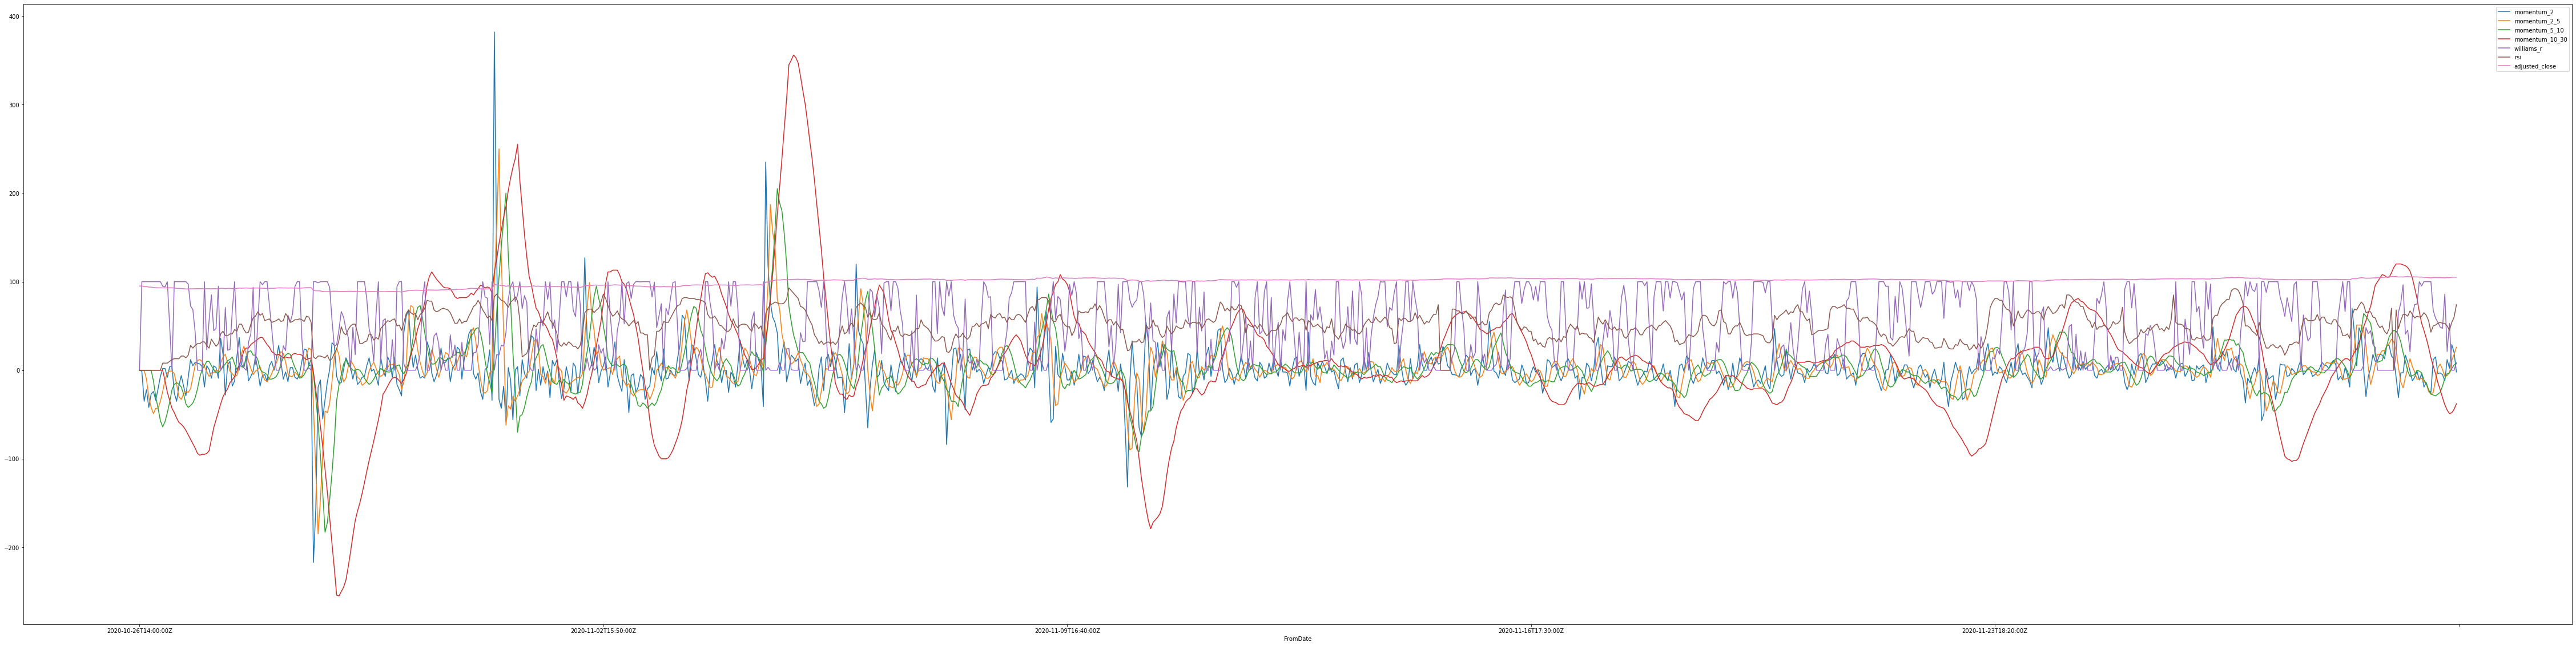

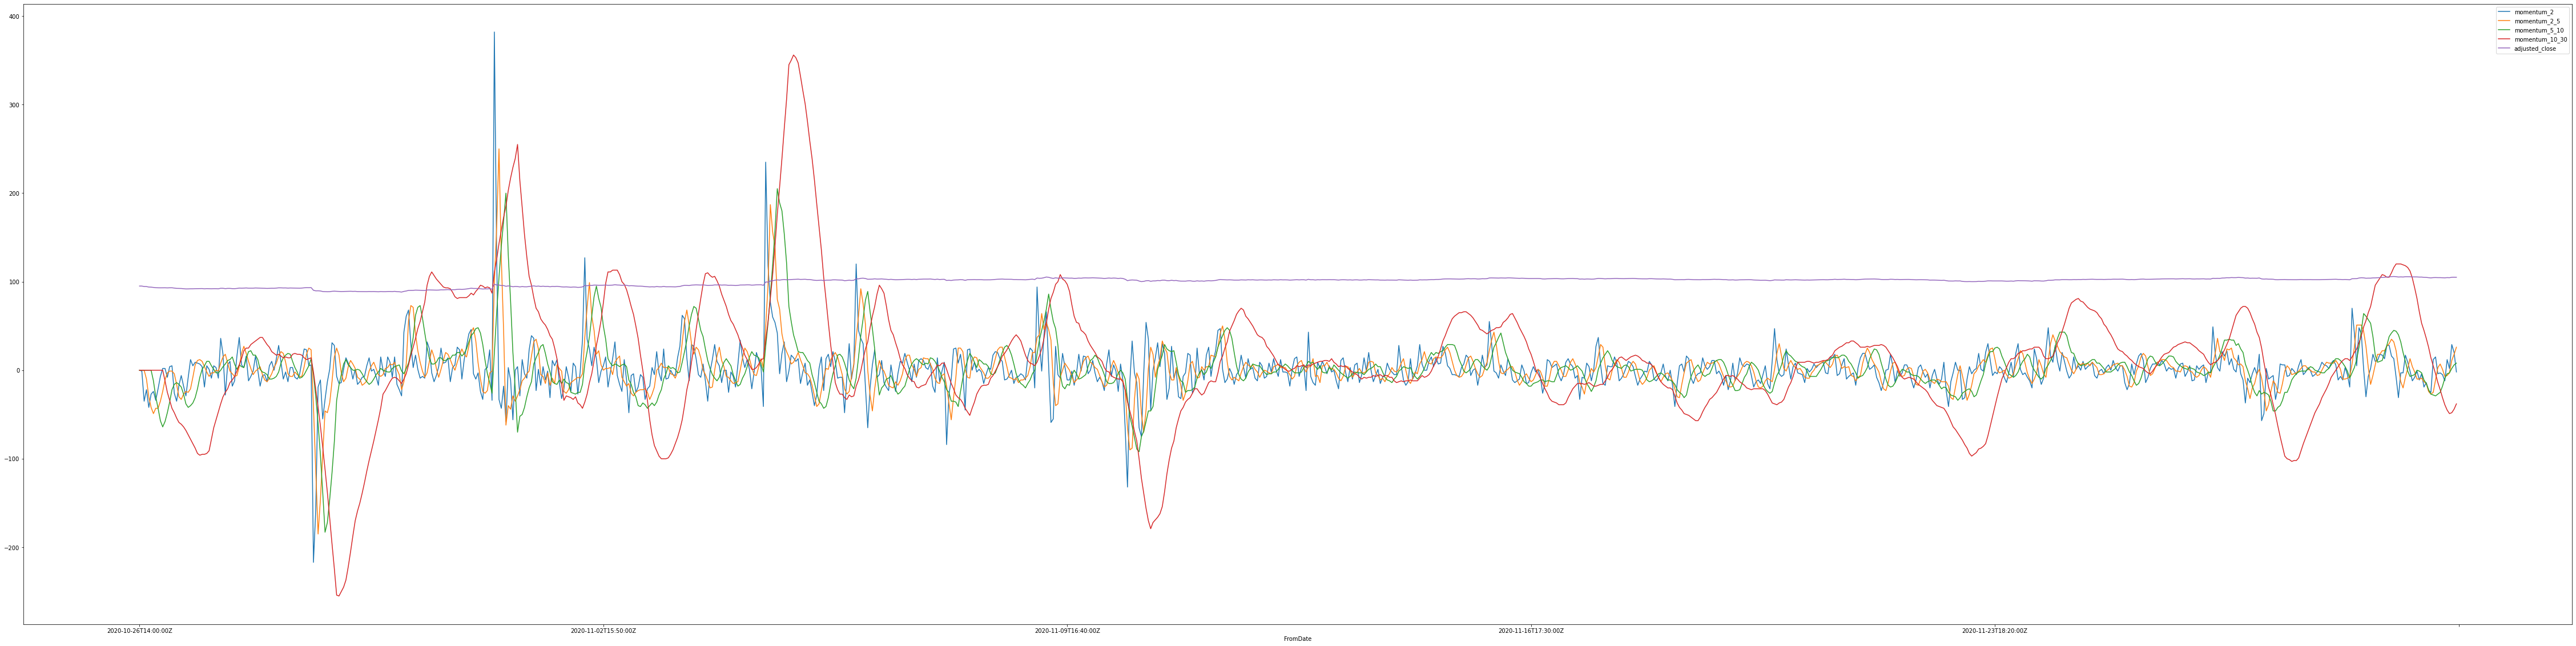

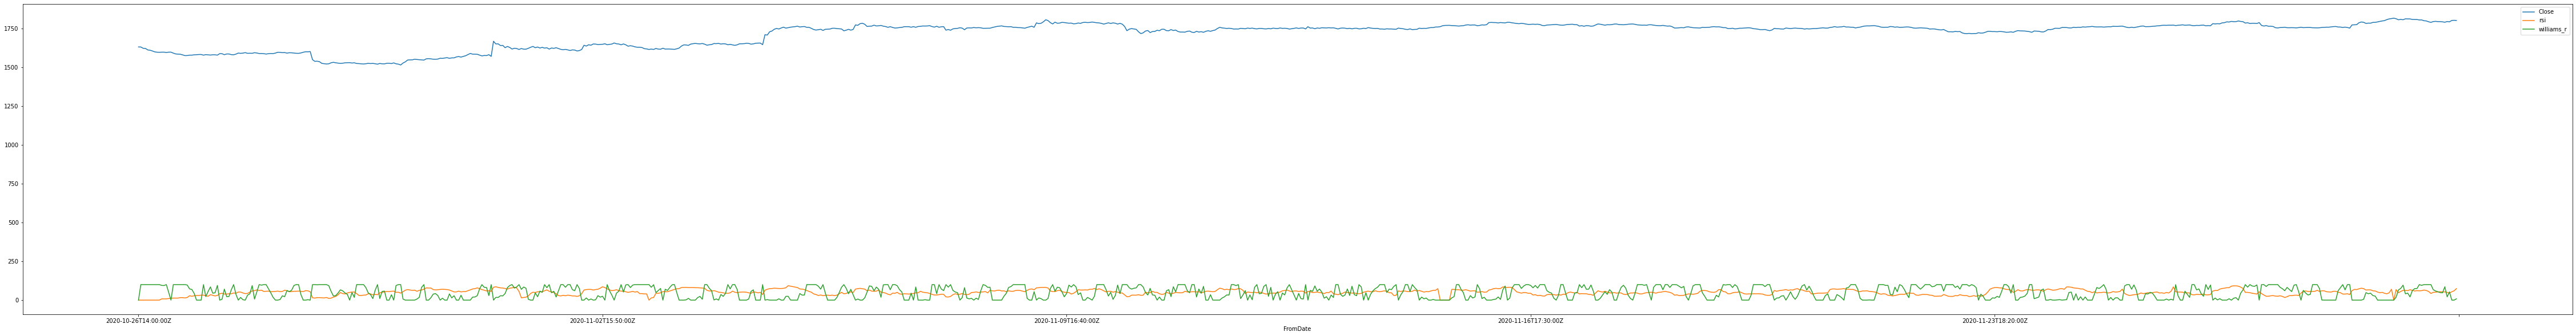

In [65]:
prepared_data["adjusted_close"] = prepared_data["Close"] / prepared_data["Close"].mean() * 100

all_indicators = prepared_data.plot(kind='line', y=["momentum_2", "momentum_2_5", "momentum_5_10", "momentum_10_30", "williams_r", "rsi", "adjusted_close"], x="FromDate", figsize=(80,20))

momentums = prepared_data.plot(kind='line', y=["momentum_2", "momentum_2_5", "momentum_5_10", "momentum_10_30", "adjusted_close"], x="FromDate", figsize=(80,20))

closings = prepared_data.plot(kind='line', y=["Close", "rsi", "williams_r"], x="FromDate", figsize=(80,10))
